In [1]:
import os
from tqdm.notebook import trange
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd

# PyTorch imports
import torch
import torch.nn.functional as F

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Device optimization

In [2]:
if torch.cuda.is_available():
    device = torch.device(type='cuda')
else:
    device = torch.device(type='cpu')
    
print(f'Using device: {device}')

Using device: cpu


## Random seed initialize

In [3]:
RANDOM_SEED = 279

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

## Load in data

In [4]:
df = pd.read_csv('sales.csv').drop(['Unnamed: 0'],axis=1)
df

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,9.7
197,177.0,9.3,6.4,12.8
198,283.6,42.0,66.2,25.5


## Data Preparation

In [5]:
features  = ['TV', 'Newspaper', 'Radio']
X = df[features]
y = df['Sales']

# scaler
sc = StandardScaler()

In [6]:
# Do train-test-split 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state=279)

X_train = torch.tensor(sc.fit_transform(X_train.values), 
                       device=device, 
                       dtype=torch.float)

y_train = torch.tensor(y_train.values, 
                       device=device,
                       dtype=torch.float)

X_train, X_val, y_train, y_val = train_test_split(X_train.numpy(),
                                                  y_train.numpy(),
                                                  test_size=0.05,
                                                  random_state=1)

X_val = torch.tensor(X_val, device=device, dtype=torch.float)
y_val = torch.tensor(y_val, device=device, dtype=torch.float)

X_train = torch.tensor(X_train, device=device, dtype=torch.float)
y_train = torch.tensor(y_train, device=device, dtype=torch.float)

X_test = torch.tensor(sc.transform(X_test.values), device=device, dtype=torch.float)
y_test = torch.tensor(y_test.values, device=device, dtype=torch.float)

## Build a multi-layer neural network

In [7]:
class MyNetwork(torch.nn.Module):
    def __init__(self, num_features):
        super(MyNetwork, self).__init__()
        self.num_features = num_features
        self.my_netwrok = torch.nn.Sequential(
            torch.nn.Linear(num_features, 128),
            torch.nn.SiLU(),
            torch.nn.Linear(128, 96),
            torch.nn.SiLU(),
            torch.nn.Linear(96, 64),
            torch.nn.SiLU(),
            torch.nn.Linear(64, 32),
            torch.nn.SiLU(),
            torch.nn.Linear(32, 16),
            torch.nn.SiLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Identity()
        )

    def forward(self, x):
        logits = self.my_netwrok(x).view(-1)
        return logits

In [8]:
train_cost, val_cost = [], []

def train(model, x, y, x_val, y_val, learning_rate=0.005, num_epochs=10, seed=279, minibatch_size=32):

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for e in trange(num_epochs):
        print(f'Epoch: {e+1}', end='')
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)

        for minibatch_idx in minibatches:
            if minibatch_idx.shape[0] == 32:
                yhat = model.forward(x[minibatch_idx])
                loss = F.mse_loss(yhat, y[minibatch_idx])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
        with torch.no_grad():
            yhat = model.forward(x)
            curr_loss = F.mse_loss(y, yhat)
            yhat_val = model.forward(x_val)
            curr_loss_val = F.mse_loss(y_val, yhat_val)
            train_cost.append(curr_loss)
            val_cost.append(curr_loss_val)
            print(f' | Train loss: {curr_loss:.3f}' , end='')
            print(f' | Val loss: {curr_loss_val:.3f}')

In [9]:
model = MyNetwork(num_features=X_train.shape[1])
model.to(device)

MyNetwork(
  (my_netwrok): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=96, bias=True)
    (3): SiLU()
    (4): Linear(in_features=96, out_features=64, bias=True)
    (5): SiLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): SiLU()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): SiLU()
    (10): Linear(in_features=16, out_features=1, bias=True)
    (11): Identity()
  )
)

In [10]:
train(model, 
      X_train, y_train,
      X_val, y_val, 
      num_epochs=100,
      learning_rate=0.005)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 218.909 | Val loss: 173.515
Epoch: 2 | Train loss: 191.277 | Val loss: 148.427
Epoch: 3 | Train loss: 101.664 | Val loss: 70.684
Epoch: 4 | Train loss: 24.875 | Val loss: 27.160
Epoch: 5 | Train loss: 7.871 | Val loss: 6.886
Epoch: 6 | Train loss: 18.034 | Val loss: 12.678
Epoch: 7 | Train loss: 10.313 | Val loss: 6.774
Epoch: 8 | Train loss: 6.484 | Val loss: 5.532
Epoch: 9 | Train loss: 2.629 | Val loss: 4.777
Epoch: 10 | Train loss: 3.553 | Val loss: 1.157
Epoch: 11 | Train loss: 2.302 | Val loss: 0.994
Epoch: 12 | Train loss: 1.974 | Val loss: 2.467
Epoch: 13 | Train loss: 0.853 | Val loss: 0.237
Epoch: 14 | Train loss: 0.929 | Val loss: 0.604
Epoch: 15 | Train loss: 0.737 | Val loss: 0.309
Epoch: 16 | Train loss: 0.412 | Val loss: 0.411
Epoch: 17 | Train loss: 0.426 | Val loss: 0.754
Epoch: 18 | Train loss: 0.360 | Val loss: 0.926
Epoch: 19 | Train loss: 0.348 | Val loss: 1.350
Epoch: 20 | Train loss: 0.329 | Val loss: 1.253
Epoch: 21 | Train loss: 0.326 | V

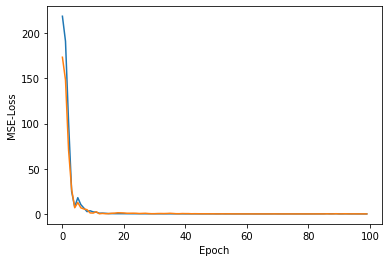

In [11]:
plt.plot(range(len(train_cost)), train_cost)
plt.plot(range(len(val_cost)), val_cost)
plt.xlabel('Epoch')
plt.ylabel('MSE-Loss')
plt.show()

In [12]:
F.mse_loss(model.forward(X_test), y_test)

tensor(0.1995, grad_fn=<MseLossBackward0>)

The network that I designed (MSE = 0.1995) outperforms RandomForest (MSE = 0.385)